In [3]:
#imports
import os
import numpy as np
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
#print('Eager execution:', tf.executing_eagerly())
print(tf.__version__)
import matplotlib.pyplot as plt
import datetime
import pickle
import pandas as pd
import random

# set random seed to be used all over
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.compat.v1.set_random_seed(SEED)
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,log_device_placement =True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = config)


2.14.0
Device mapping: no known devices.


In [4]:
# Path to the directory containing the project files (CHANGE THIS PATH TO THE DIRECTORY ON YOUR COMPUTER)
PROJECT_ROOT_DIR = os.getcwd() + '/'

# Path to the directory containing the dataset relative to project file
DATA_DIR = './GTSRB_dataset(1)/GTSRB_dataset/'

#path to the directory you want to use for saving models relative to the project file
MODEL_DIR = './'

In [5]:
# Funciton for loading the dataset
# Code from advml-traffic-sign (https://github.com/inspire-group/advml-traffic-sign)
def load_dataset_GTSRB(n_channel=3, train_file_name=None):
    """
    Load GTSRB data as a (datasize) x (channels) x (height) x (width) numpy
    matrix. Each pixel is rescaled to the range [0,1].
    """

    def load_pickled_data(file, columns):
        """
        Loads pickled training and test data.

        Parameters
        ----------
        file    : string
                          Name of the pickle file.
        columns : list of strings
                          List of columns in pickled data we're interested in.

        Returns
        -------
        A tuple of datasets for given columns.
        """

        with open(file, mode='rb') as f:
            dataset = pickle.load(f)
        return tuple(map(lambda c: dataset[c], columns))

    def preprocess(x, n_channel):
        """
        Preprocess dataset: turn images into grayscale if specified, normalize
        input space to [0,1], reshape array to appropriate shape for NN model
        """

        if n_channel == 3:
            # Scale features to be in [0, 1]
            x = (x / 255.).astype(np.float32)
        else:
            # Convert to grayscale, e.g. single Y channel
            x = 0.299 * x[:, :, :, 0] + 0.587 * x[:, :, :, 1] + \
                0.114 * x[:, :, :, 2]
            # Scale features to be in [0, 1]
            x = (x / 255.).astype(np.float32)
            x = x[:, :, :, np.newaxis]
        return x

    # Load pickle dataset
    if train_file_name is None:
        x_train, y_train = load_pickled_data(
            PROJECT_ROOT_DIR + DATA_DIR + 'train.p', ['features', 'labels'])
    else:
        x_train, y_train = load_pickled_data(
            PROJECT_ROOT_DIR + DATA_DIR + train_file_name, ['features', 'labels'])
    x_val, y_val = load_pickled_data(
        PROJECT_ROOT_DIR + DATA_DIR + 'valid.p', ['features', 'labels'])
    x_test, y_test = load_pickled_data(
        PROJECT_ROOT_DIR + DATA_DIR + 'test.p', ['features', 'labels'])

    # Preprocess loaded data
    x_train = preprocess(x_train, n_channel)
    x_val = preprocess(x_val, n_channel)
    x_test = preprocess(x_test, n_channel)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [6]:
# Load the images and labels. These images are RGB so we have 3 channels
imgs_train, labels_train, imgs_val, labels_val, imgs_test, labels_test = load_dataset_GTSRB(n_channel=3)

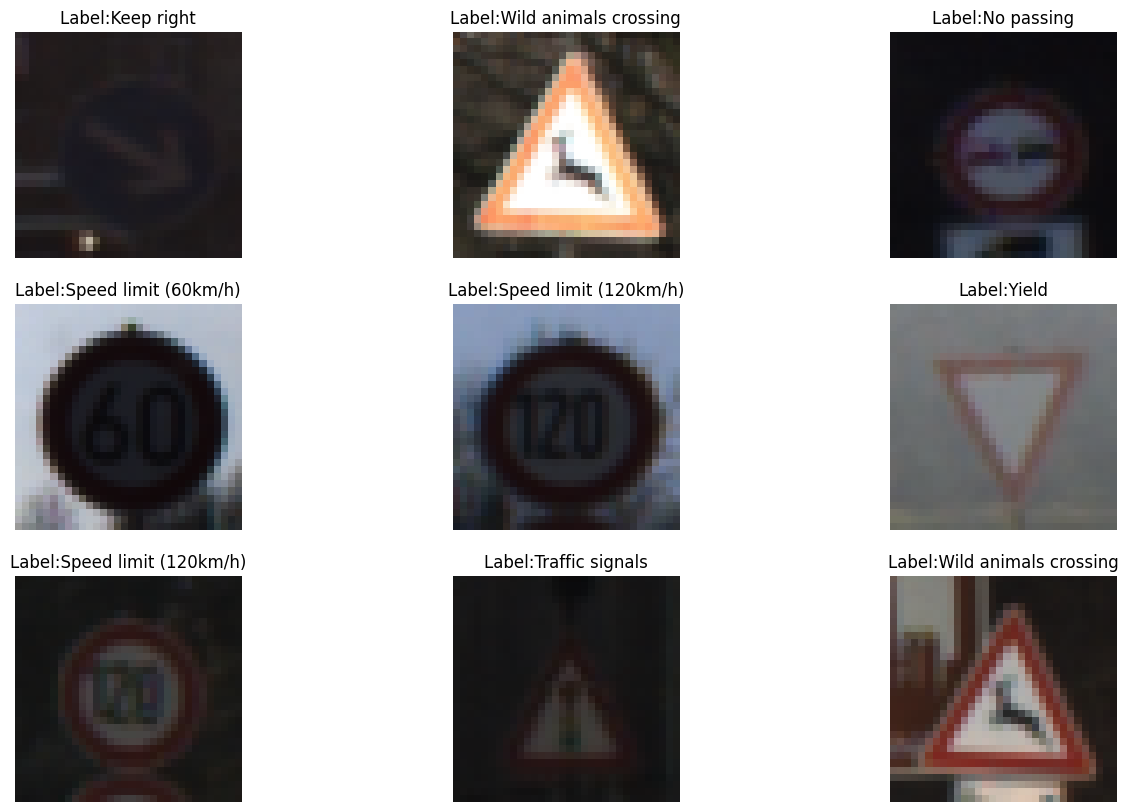

In [7]:
# Read the sign names
signnames = pd.read_csv(PROJECT_ROOT_DIR + './GTSRB_dataset(1)/GTSRB_dataset/signnames.csv').values[:, 1]

# Plot a few images to check if the data makes sense (note that the quality of some of the images is pretty low)
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(imgs_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(imgs_train[i[0]])
    plt.title('Label:' + str(signnames[labels_train[i[0]]]))
    plt.axis('off')

In [8]:
# Set constants (GTSRB)
NUM_LABELS = 43                             # Number of labels or classes for classification
BATCH_SIZE = 128                            # Size of batch
HEIGHT = 32                                 # Height of input image
WIDTH = 32                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 43                             # Number of output dimension

# Set training hyperparameters
NUM_EPOCH = 50                             # Number of epoch to train
LR = 0.0002                                 # Learning rate
RBW = True #restore best weights
PATIENCE = 5# how many epochs between improvements

INPUT_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)  # Input shape of model
IMG_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)

In [9]:
#avoiding future overfitting
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=RBW)]

In [10]:
# setting up labels
from tensorflow.keras.utils import to_categorical

#Convert the labels to one-hot encoding (to input to the models)

#make a copy of 500 test images before we encode for adversarial testing.
imgs_adv = imgs_test[0:500,:,:,:].copy()
labels_adv = labels_test[0:500].copy()




labels_train_cat = to_categorical(labels_train, NUM_LABELS)
labels_test_cat = to_categorical(labels_test, NUM_LABELS)
labels_val_cat = to_categorical(labels_val, NUM_LABELS)

#for testing adversarial inputs
labels_adv_cat = to_categorical(labels_adv,NUM_LABELS)

print('Labels train shape: {}'.format(labels_train.shape))
print('Labels train catagorical shape: {}\n'.format(labels_train_cat.shape))
print('Labels Adver shape: {}'.format(labels_adv.shape))
print('Labels Adver catagorical shape: {}'.format(labels_adv_cat.shape))

print('Imgs Adver shape: {}'.format(imgs_adv.shape))

Labels train shape: (34799,)
Labels train catagorical shape: (34799, 43)

Labels Adver shape: (500,)
Labels Adver catagorical shape: (500, 43)
Imgs Adver shape: (500, 32, 32, 3)


In [11]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model


#create our model
def build_model():
    #create VGG16 model with properties we want.
    base_model = tf.keras.applications.VGG16(include_top=False,
                                    weights="imagenet",
                                    input_shape=INPUT_SHAPE)

    #create fully connected layers
    #by not including the top we need to create these layers ourselves
    #input and output layers
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add a fully-connected layer
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer with 43 classes
    predictions = Dense(OUTPUT_DIM, activation='softmax', name ='softmax')(x)

    # The model
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])



    return model



In [37]:
## Load the saved the model
from tensorflow.keras.models import load_model


#The followiwng line should be uncommented with your first run (to save the model)
#model.save(MODEL_DIR +'VGG_best.keras')


#load our already trained model
# Your earlier directories should change to match this one
#You should be able to load the model once trained. The following line is used for that.
model = load_model( MODEL_DIR +'vgg_best.h5')



In [13]:
#Task3

In [14]:
#Adversarial Defense
#Now let’s defend against adversarial attacks. 
#This [notebook](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_training_mnist.ipynb) 
#is a good start for adversarial training.

#Due to its complexity and the time taken to build an adversarial-trained model, we decided to give the model to you, 
#and your only task will be to analyze it. The VGG classifier from earlier parts is used to build the adversarial model. 
#New adversarial images were generated and used to build the new model. This model is provided in your assignment, and you will need to analyze it.


In [15]:
#from art.estimators.classification import KerasClassifier
#from art.defences.trainer import AdversarialTrainer
#from art.attacks.evasion import ProjectedGradientDescent,FastGradientMethod


#model = load_model( MODEL_DIR +'VGG_best.h5')

#robustClassifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits = False)


#attackPgd = ProjectedGradientDescent(estimator = robustClassifier,
#                                         eps=0.1,
#                                         max_iter=40,
#                                         batch_size=64)


#advTrainer = AdversarialTrainer(robustClassifier,attackFGSM,ratio=.5)


#advTrainer.fit(imgs_train, labels_train_cat, nb_epochs=25, batch_size=16)

#model.save(PROJECT_ROOT_DIR + MODEL_DIR +'adversarial_vgg.h5')

In [22]:
tf.compat.v1.disable_eager_execution()

In [44]:
model = load_model( MODEL_DIR +'vgg_best.h5')

In [33]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import ProjectedGradientDescent

In [47]:
# Clean train images
accuracy_clean_train = model.evaluate(imgs_train, labels_train_cat)[1]
print(f'Accuracy on clean train images: {accuracy_clean_train * 100:.2f}%')

Accuracy on clean train images: 97.05%


In [40]:
# Clean subset of test images
accuracy_clean_test = model.evaluate(imgs_test[:500], labels_test_cat[:500])[1]
print(f'Accuracy on clean test subset: {accuracy_clean_test * 100:.2f}%')

Accuracy on clean test subset: 93.80%


In [45]:
# Attack subset of test images - FGSM
classifier = KerasClassifier(model=model, clip_values=(0, 1))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.1)
imgs_adv_fgsm = attack_fgsm.generate(imgs_adv)
loss_test_fgsm, accuracy_test_fgsm = model.evaluate(imgs_adv_fgsm, labels_adv_cat)
perturbation_fgsm = np.mean(np.abs((imgs_adv_fgsm - imgs_adv)))
print(f'Accuracy on FGSM attacked test data: {accuracy_test_fgsm * 100:.2f}%')
print(f'Average perturbation (FGSM): {perturbation_fgsm:.2f}')

Accuracy on FGSM attacked test data: 46.80%
Average perturbation (FGSM): 0.09


In [46]:
# Attack subset of test images - PGD
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.1)
imgs_adv_pgd = attack_pgd.generate(imgs_adv)
loss_test_pgd, accuracy_test_pgd = model.evaluate(imgs_adv_pgd, labels_adv_cat)
perturbation_pgd = np.mean(np.abs((imgs_adv_pgd - imgs_adv)))
print(f'Accuracy on PGD attacked test data: {accuracy_test_pgd * 100:.2f}%')
print(f'Average perturbation (PGD): {perturbation_pgd:.2f}')

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on PGD attacked test data: 43.60%
Average perturbation (PGD): 0.06


In [42]:
model = load_model( MODEL_DIR +'adversarial_pgd.h5')

In [35]:
# Clean train images
accuracy_clean_train = model.evaluate(imgs_train, labels_train_cat)[1]
print(f'Accuracy on clean train images: {accuracy_clean_train * 100:.2f}%')

Accuracy on clean train images: 99.73%


In [36]:
# Clean subset of test images
accuracy_clean_test = model.evaluate(imgs_test[:500], labels_test_cat[:500])[1]
print(f'Accuracy on clean test subset: {accuracy_clean_test * 100:.2f}%')

Accuracy on clean test subset: 96.60%


In [43]:
# Attack subset of test images - FGSM
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.1)
imgs_adv_fgsm = attack_fgsm.generate(imgs_adv)
loss_test_fgsm, accuracy_test_fgsm = model.evaluate(imgs_adv_fgsm, labels_adv_cat)
perturbation_fgsm = np.mean(np.abs((imgs_adv_fgsm - imgs_adv)))
print(f'Accuracy on FGSM attacked test data: {accuracy_test_fgsm * 100:.2f}%')
print(f'Average perturbation (FGSM): {perturbation_fgsm:.2f}')

Accuracy on FGSM attacked test data: 44.20%
Average perturbation (FGSM): 0.09


In [34]:
# Attack subset of test images - PGD
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.1)
imgs_adv_pgd = attack_pgd.generate(imgs_adv)
loss_test_pgd, accuracy_test_pgd = model.evaluate(imgs_adv_pgd, labels_adv_cat)
perturbation_pgd = np.mean(np.abs((imgs_adv_pgd - imgs_adv)))
print(f'Accuracy on PGD attacked test data: {accuracy_test_pgd * 100:.2f}%')
print(f'Average perturbation (PGD): {perturbation_pgd:.2f}')

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on PGD attacked test data: 81.20%
Average perturbation (PGD): 0.06
